# Teeth Disease Classification

## Imports

In [43]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, NASNetMobile, Xception, ResNet50
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings('ignore')


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
# access google drive
try:  
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR_PATH = '/content/drive/MyDrive/Teeth_Dataset'
except:
    DATA_DIR_PATH = os.path.join(os.getcwd(), 'Teeth_Dataset')


## Data Preparation

In [6]:

TRAIN_DATA_PATH = os.path.join(DATA_DIR_PATH, 'Training')
VALID_DATA_PATH = os.path.join(DATA_DIR_PATH, 'Validation')
TEST_DATA_PATH = os.path.join(DATA_DIR_PATH, 'Testing')

In [7]:
Train_classes_path =  [os.path.join(TRAIN_DATA_PATH,f) for f in os.listdir(TRAIN_DATA_PATH)]
Valid_classes_path =  [os.path.join(VALID_DATA_PATH,f) for f in os.listdir(TRAIN_DATA_PATH)]
Test_classes_path =  [os.path.join(TEST_DATA_PATH,f) for f in os.listdir(TRAIN_DATA_PATH)]
Train_classes_path

['d:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\CaS',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\CoS',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\Gum',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\MC',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\OC',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\OLP',
 'd:\\Cellula Tech CV intern\\First session\\Teeth Project\\Teeth_Dataset\\Training\\OT']

### Data Visualization

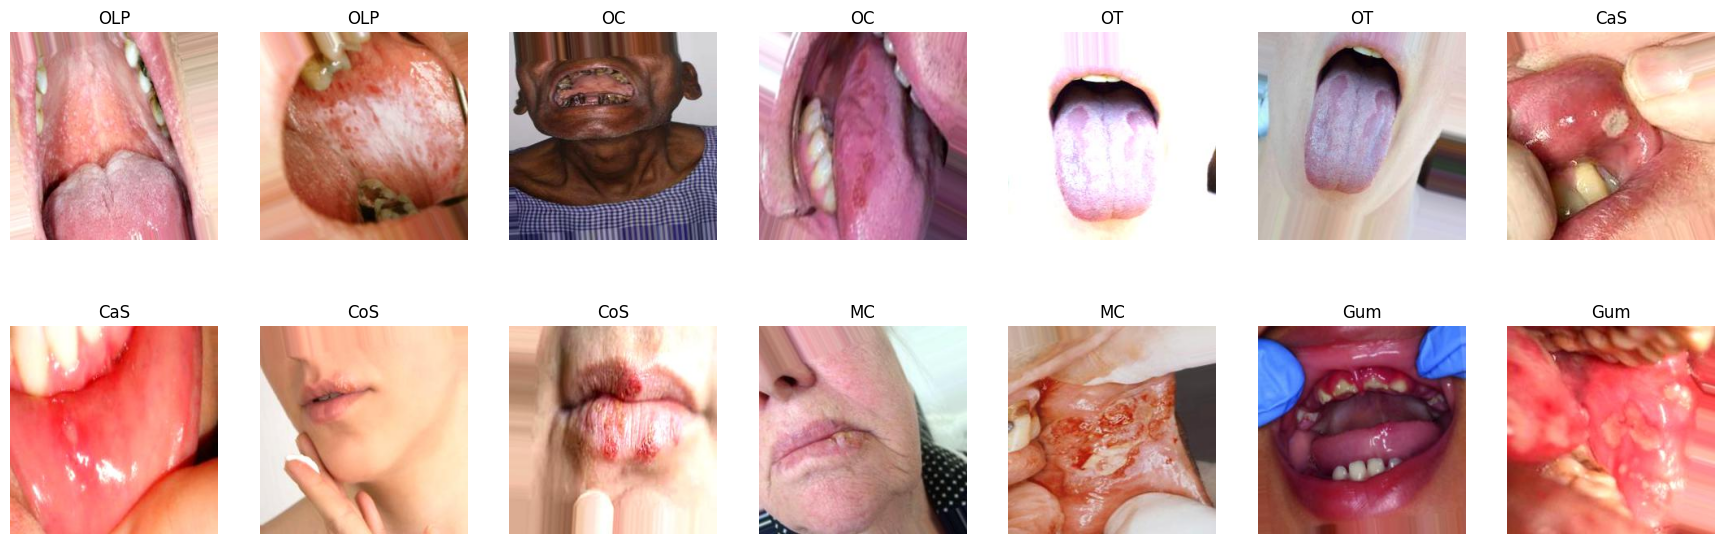

In [7]:
# For visualization
plt.figure(figsize=(22, 7))
counter = 1
for class_path in Train_classes_path:
    rand_train_img_path =  [os.path.join(class_path, f) for f in os.listdir(class_path)]
    for i in rand_train_img_path[:2]:
        plt.subplot(2, 7, counter)
        img = plt.imread(i)
        plt.axis('off')
        plt.title(os.path.basename(class_path))
        plt.imshow(img)
        counter += 1

### Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [38]:

train_generator = train_datagen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(120, 120),
    batch_size=100,
    class_mode='categorical',  # Use 'categorical' if your labels are one-hot encoded
    shuffle=True
)

valid_generator = test_datagen.flow_from_directory(
    VALID_DATA_PATH,
    target_size=(120, 120),
    batch_size=100,
    class_mode='categorical',
    shuffle=True

)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [ ]:
# # Define batch size and image size
# batch_size = 64
# img_size = (180, 180)

# # Load the training dataset with categorical labels
# train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     TRAIN_DATA_PATH,
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical',
#     shuffle=True
# )

# # Load the validation dataset with categorical labels
# val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     VALID_DATA_PATH,
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical',
#     shuffle=True
# )

# # Load the test dataset with categorical labels
# test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     TEST_DATA_PATH,
#     image_size=img_size,
#     batch_size=batch_size,
#     label_mode='categorical',
#     shuffle=False
# )


-------

## VGG16 model

In [25]:
# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

In [26]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])


In [27]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,078,087 (65.15 MB)

 Trainable params: 2,363,399 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=valid_generator,
    # validation_steps=valid_generator.samples // valid_generator.batch_size
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 190s 9s/step - accuracy: 0.2139 - loss: 3.0770 - val_accuracy: 0.4747 - val_loss: 1.4799
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 207s 10s/step - accuracy: 0.4181 - loss: 1.5459 - val_accuracy: 0.6089 - val_loss: 1.1880
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.5127 - loss: 1.3737 - val_accuracy: 0.6440 - val_loss: 1.0634
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 197s 9s/step - accuracy: 0.5368 - loss: 1.2398 - val_accuracy: 0.6809 - val_loss: 0.9558
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.5877 - loss: 1.1500 - val_accuracy: 0.7101 - val_loss: 0.8999
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.5831 - loss: 1.1307 - val_accuracy: 0.7500 - val_loss: 0.7844
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 169s 8s/step - accuracy: 0.6184 - loss: 1.0474 - val_accuracy: 0.7636 - val_loss: 0.7265
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.6335 - loss: 1.0293 - val_accuracy: 0.7558 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.9325 - loss: 0.2629
Test accuracy: 0.94


<Axes: >

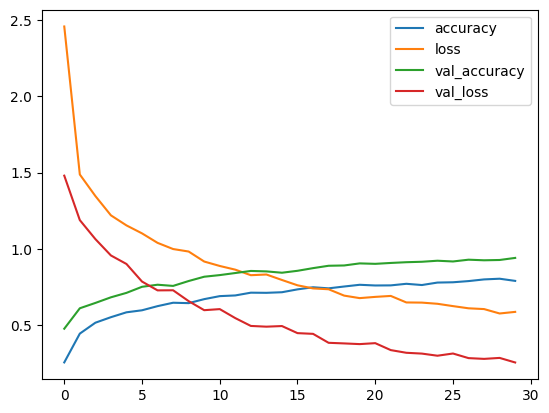

In [ ]:
loo_acc_df = pd.DataFrame(history.history)
loo_acc_df.plot()

### Unfreeze some layers

In [28]:
# Unfreeze the last few layers (e.g., the last 2 layers)
for layer in base_model.layers[-2:]:
    layer.trainable = True

In [29]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 200)            │        25,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,331,847 (58.49 MB)

 Trainable params: 2,976,967 (11.36 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [31]:
initial_learning_rate = 0.01
decay_steps = 10000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)


In [32]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping]
)


Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 543ms/step - accuracy: 0.3024 - loss: 1.7900 - val_accuracy: 0.6514 - val_loss: 1.0391
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.2493 - val_accuracy: 0.7500 - val_loss: 0.6829
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 54s 559ms/step - accuracy: 0.5794 - loss: 1.1524 - val_accuracy: 0.7383 - val_loss: 0.7494
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.6562 - loss: 0.7984 - val_accuracy: 1.0000 - val_loss: 0.3404
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 570ms/step - accuracy: 0.6910 - loss: 0.8830 - val_accuracy: 0.8154 - val_loss: 0.4931
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.8438 - loss: 0.5082 - val_accuracy: 0.7500 - val_loss: 1.5695
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 570ms/step - accuracy: 0.7323 - loss: 0.7449 - val_accuracy: 0.8594 - val_loss: 0.3665
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8438 - loss: 0.3903 - val_accuracy: 

In [35]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.9482 - loss: 0.1498
Test accuracy: 0.94


<Axes: >

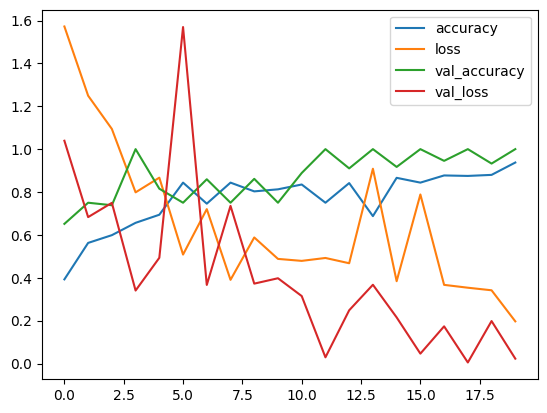

In [37]:
loo_acc_df = pd.DataFrame(history.history)
loo_acc_df.plot()

### Making the batch size bigger

In [39]:
train_generator.batch_size = 100
valid_generator.batch_size = 100

In [40]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9091 - loss: 0.2782 - val_accuracy: 0.9710 - val_loss: 0.0886
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9600 - loss: 0.1817 - val_accuracy: 1.0000 - val_loss: 0.0516
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9397 - loss: 0.1926 - val_accuracy: 0.9720 - val_loss: 0.0764
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9400 - loss: 0.1494 - val_accuracy: 1.0000 - val_loss: 0.0474
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9390 - loss: 0.1848 - val_accuracy: 0.9800 - val_loss: 0.0667
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9300 - loss: 0.1797 - val_accuracy: 1.0000 - val_loss: 0.0290
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9532 - loss: 0.1463 - val_accuracy: 0.9840 - val_loss: 0.0676
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8851 - loss: 0.2366 - val_accuracy: 1.0000 - val_l

In [41]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.9820 - loss: 0.0483
Test accuracy: 0.98


<Axes: >

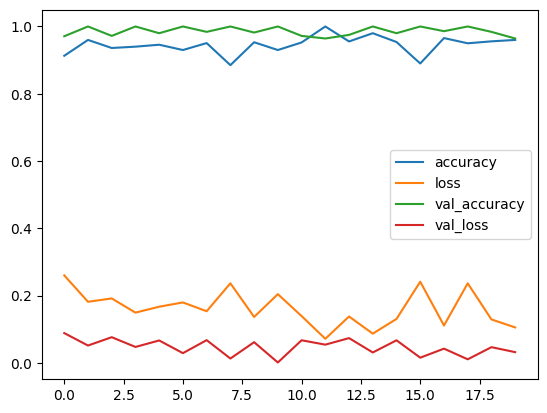

In [42]:
loo_acc_df = pd.DataFrame(history.history)
loo_acc_df.plot()

In [44]:
model.save("VGG16_fine_tuned.h5")